# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

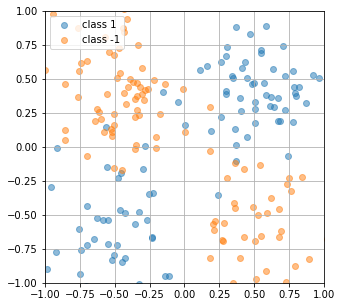

In [347]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [2]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        
            
        ##should have in mind, ||x_i - y_j||^2 = ||x_i||^2 +||y_j||^2 -2x_i.y_j
        
        X_norm = np.sum (X**2, axis = 1)#size N, ||x_i||^2
        Y_norm = np.sum (Y**2, axis = 1)#size M, ||y_j||^2
        
        X_Y = X @ Y.T #x_i.y_j
        
        X_Y_dist = 2*X_Y - X_norm[:,np.newaxis] - Y_norm[np.newaxis,:]
        
        return  np.exp(X_Y_dist/(2*self.sigma**2)) #element-wise product  ## Matrix of shape NxM
    
##This code does what it is expected to, it has been tested with a few examples

In [3]:
class Linear:
    def kernel(self,X,Y):
        return  X @ Y.T #linear kernel, NxM


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [350]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.support_label = None #added this attribute
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X)
        
        # Lagrange dual problem
        def loss(alpha):
            lamda = y * alpha # * is the component-wise product, it is faster than the matrix product
            return (1/2)*(lamda.T @K @ lamda).item() - np.sum(alpha)#'''--------------dual loss ------------------ ''' 
        ## we minimize -g(alpha)
        
        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return y* (K @ (y*alpha)) - np.ones(N)# '''----------------partial derivative of the dual loss wrt alpha -----------------'''


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: np.dot(alpha,y)  # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha: y    #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        
        fun_ineq = lambda alpha: - np.concatenate([alpha, -alpha], axis = 0)  + np.concatenate([self.C*np.ones(N), np.zeros(N)], axis = 0) 
            # '''---------------function defining the inequality constraint-------------------'''     
        
        jac_ineq = lambda alpha: -np.block( [[np.eye(N)], [ -np.eye(N) ]])  
        ##becarefull the ineq should be b - A alpha!!
        # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x
        
        ## Assign the required attributes

        
        self.margin_points = (self.alpha < self.C - self.epsilon) * (self.alpha > self.epsilon)
        
        #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        
        
        self.b = np.sum(self.margin_points * ( y - K @ (self.alpha*y) ) ) / np.sum(self.margin_points) 
        #''' -----------------offset of the classifier------------------ '''
            
        self.norm_f = ( (self.alpha*y).T @ K @ (self.alpha*y) ).item()
        # '''------------------------RKHS norm of the function f ------------------------------'''
        
        
        self.support =  X[self.alpha > self.epsilon ,:]
        #concatenation of x that have alpha != 0, we keep support vectors
        
        self.support_label = y [ self.alpha > self.epsilon ]
        self.alpha = self.alpha[ self.alpha> self.epsilon ] 
        #we keep alpha of support vectors

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x,self.support)
        return K@(self.alpha*self.support_label) 
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 43


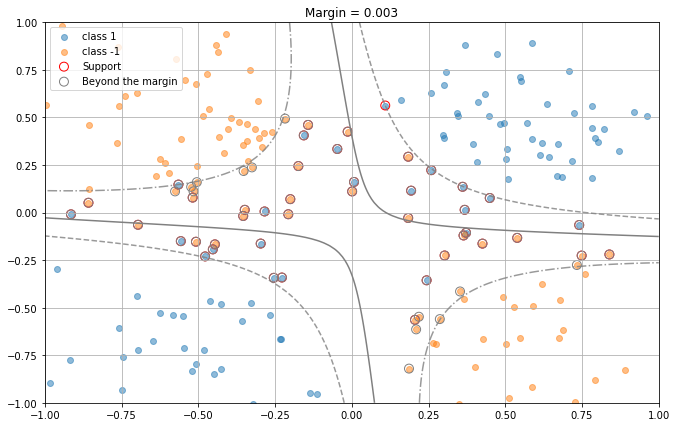

In [351]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

# Kernel Regression

## Loading the data

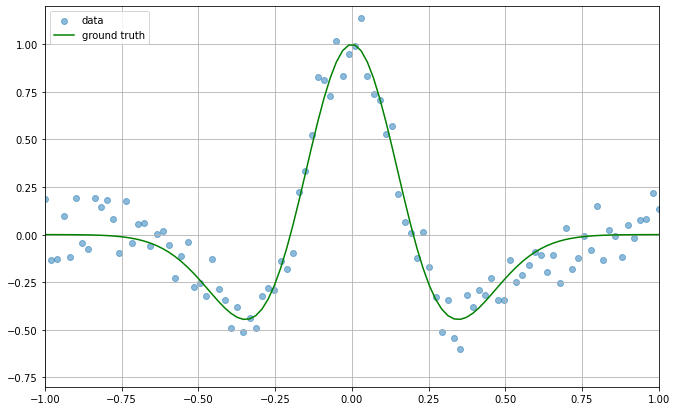

In [352]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [353]:
class KernelRR:
    
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel    
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'
        
    def fit(self, X, y):
        self.support = X
        
        
        
        K = self.kernel(X,X)
        #print(K.shape)
        N = X.shape[0]
        #print(N)
        inv = np.linalg.inv( K + self.lmbda*np.eye(N) )
        
        self.alpha = inv @ y
        self.b = (y-K@self.alpha).mean()
        
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x,self.support) #size N*number datapoints
        return K@self.alpha

    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return regression_function(X)+self.b

    
class MultivariateKernelRR:      
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'
    
    def fit(self, X, y):
        self.support = X
        
        K = self.kernel(X,X)
        #print(K.shape)
        N = X.shape[0]
        #print(N)
        inv = np.linalg.inv( K + self.lmbda*np.eye(N) )
        
        self.alpha = inv @ y
        #self.alpha = np.linalg.inv(K + self.lmbda * np.eye(N))@ y
        
        self.b = (y-K@self.alpha).mean()
        
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x,self.support) #size N*number datapoints
        return K@self.alpha
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+np.expand_dims(self.b,axis=0)
    

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

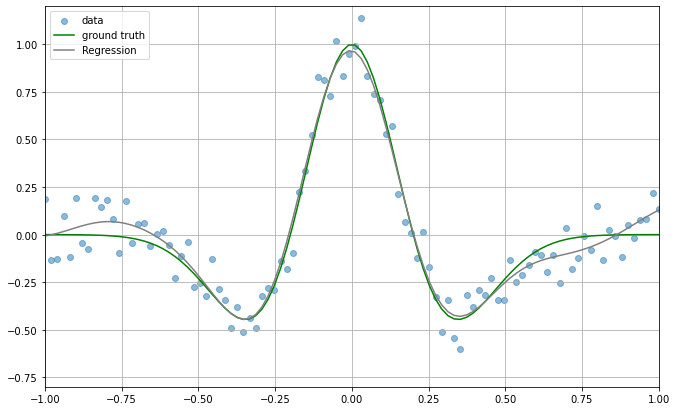

In [354]:
sigma = 0.2
lmbda = .1
kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'].reshape(-1,1), train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

In [4]:
class KernelPCA:
    
    def __init__(self,kernel, r=3):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        
        K = kernel(X,X) 
        N = self.support.shape[0]
        G = (np.eye(N) - (1/N)*np.ones((N,N))) @ K @ (np.eye(N) - (1/N)*np.ones((N,N)))
        #G = (np.eye(N) - np.ones((N,N))) @ K @ (np.eye(N) - np.ones((N,N)))
        #G = K
        #we use the definition of the centered kernel matrix given the uncentered kernel matrix K
        #G /= N 
        #G is the Gramm matrix obtained in question 1
        
        
        # Compute the eigenvalues and eigenvectors of the kernel matrix
        eigenvalues, eigenvectors = np.linalg.eigh(G)
        
        # Find the top r eigenvalues and eigenvectors 
        indices = np.argsort(eigenvalues)[::-1][:self.r]
    
        self.lmbda=eigenvalues[indices].real
        self.alpha=eigenvectors[:, indices].real
        
       
        
    def transform(self,x):
        # Input : matrix x of shape M data points times d dimension
        # Output: vector of size M
        
        #eigenvector of the decomposition
        
        K_x = self.kernel(self.support,x)
        K   = self.kernel(self.support,self.support)
        
        N , M = K_x.shape
        
        #becareful the formula for centered gramm matrix in the course don't directly apply here
        K_xcent = K_x - (1/N)*np.ones((N,N))@K_x -(1/N)*K@np.ones((N,M))
        K_xcent += (1/N**2)* np.ones((1,N))@K @np.ones((N,1)) 
        #K_xcent = (np.eye(N) - np.ones((N,N))) @ K @ (np.eye(N) - np.ones((N,N)))
        true_alpha = self.alpha/(np.sqrt(N))
        
        for iter_ in range(true_alpha.shape[1]):
            true_alpha[:,iter_] = true_alpha[:,iter_]/(np.sqrt(self.lmbda[iter_]))
        #G /= N 
        #G /=N
        
        return K_xcent.T @ true_alpha
    


### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

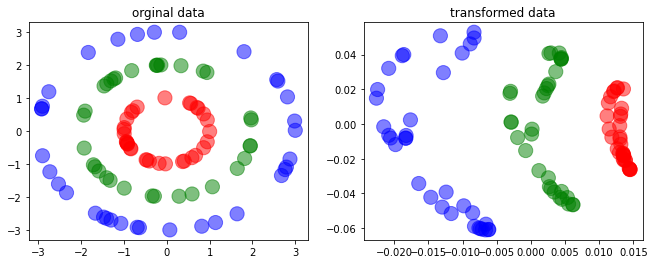

In [5]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

sigma = 4.
kernel = RBF(sigma).kernel
pca = KernelPCA(kernel, r=4)
pca.compute_PCA(train_set['x'])


pca_components = pca.transform(test_set['x'])

fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(test_set['x'], test_set['y'], ax[0], title='orginal data')
scatter_label_points(pca_components[:,[2,1]],test_set['y'], ax[1], title= 'transformed data')


We can display a 3D version of the pca components.

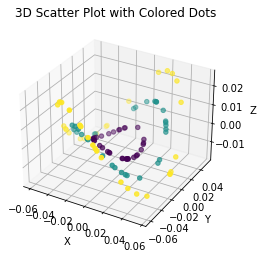

In [6]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:,0], pca_components[:,1], pca_components[:,3] , c=test_set['y'])

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot with Colored Dots')

plt.show()

We display the different functions $f_0, f_1, f_2, f_3$ obtained by the 4 first eigenvectors along the x-axis.

We see that the functions $f_0, f_1$ are odd, so they can't linearly separate the data. But $f_2, f_3$ are even, points on a circle can be distinguished from points of another circle. 

Text(0.5, 1.0, 'f_0')

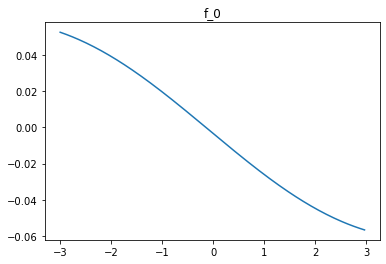

In [7]:
x_test = np.array([[6*(i/200) -3 , 0] for i in range(200)])

pca_components = pca.transform(x_test)

plt.plot(x_test[:,0], pca_components[:,0])
plt.title("f_0")


Text(0.5, 1.0, 'f_1')

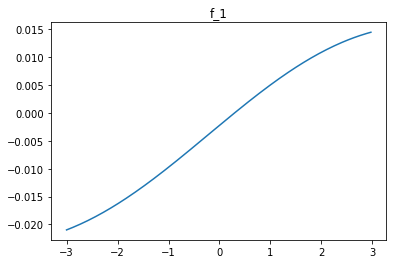

In [8]:
plt.plot(x_test[:,0], pca_components[:,1])
plt.title("f_1")

Text(0.5, 1.0, 'f_2')

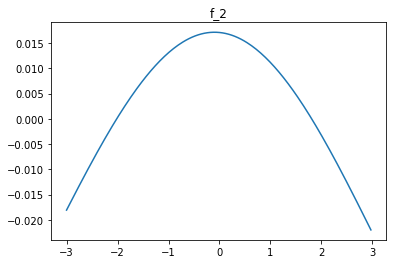

In [9]:
plt.plot(x_test[:,0], pca_components[:,2])
plt.title("f_2")

Text(0.5, 1.0, 'f_3')

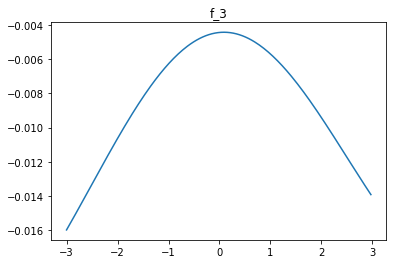

In [10]:
plt.plot(x_test[:,0], pca_components[:,3])
plt.title("f_3")

# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

In [377]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)
    
    def fit(self,train):
        #Learning the PCA decomposition, learning how to encode 
        train = train.reshape(train.shape[0],-1)
        self.pca.compute_PCA(train)
        encoded_train = self.pca.transform(train)
        
        #learning the components for the ridge regression, learning how to decode 
        self.ridge_reg.fit(encoded_train ,train)  
        
    def denoise(self,test):
        image_shape = test.shape
        test = test.reshape(test.shape[0],-1)
        
        #encoding in the PCA componenents space
        encoded_test = self.pca.transform(test)
        
        #decoding to the space of images
        denoised_decoded_data = self.ridge_reg.predict(encoded_test)
        
        return denoised_decoded_data.reshape(image_shape)
    
     

### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?

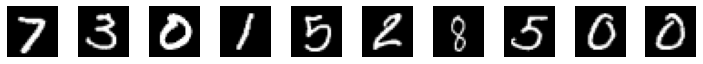

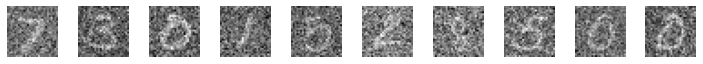

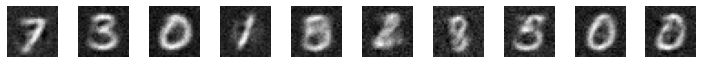

In [378]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']


dim_pca =80
lmbda = .0001
sigma_encoder =8.
sigma_decoder =.5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(data['train'])
pred = denoiser.denoise(data['test'])

plot_multiple_images(clean_data['test'])
plot_multiple_images(data['test'])
plot_multiple_images(pred)